# Notebook to view parsed data from sql database 
###Also view time-series variation in Monte-Carlo time

Author: Venkitesh Ayyar (vayyar@bu.edu) \
Nov 19, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sqlite3

import subprocess as sp
import os 
import glob
import pandas as pd
import itertools
import yaml
import sys

In [3]:
import gvar as gv

In [4]:
%matplotlib widget

In [5]:
sys.path.append('modules')
from modules_parse_hmc_Grid import *
from modules_plot import *
# from modules_measurement import *

## Read summary HMC data from table

In [6]:
### Read sql database
fname2='Stored_data/sql_dbase_files/summary_hmc_data.db'
conn = sqlite3.connect(fname2)
df_summary=pd.read_sql_query("SELECT * FROM summary",conn)


# # Convert strings to gvars for analysis
gvar_key_list=['plaq', 'sus_plaq', 'kurt_plaq', 'polyakov', 'sus_poly', 'kurt_poly', 'traj_time']
for key in gvar_key_list:        
#     df_summary[key] = df_summary[key].apply(lambda x: gv.gvar(x))
    df_summary[key] = df_summary[key].apply(lambda x: f_conv_strg_to_gvar(x))

In [7]:
df_summary.head()

,beta,mf,Lx,Lt,run_label,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf,run_key
0,10.0,0.1,16,8,cold-start,0.412963(77),0.00208(28),1.53(38)e-07,3,0.00389(20),0.0138(17),1.38(26)e-07,1,141.294(25),80.864198,172,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
1,10.0,0.1,16,8,hot-start,0.413407(61),0.00130(16),1.34(32)e-07,3,0.00356(18),0.0116(28),3.6(2.3)e-07,1,141.410(26),78.125000,170,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
2,10.2,0.1,16,8,cold-start,0.44180(10),0.00350(40),1.24(26)e-07,5,0.00362(18),0.0118(16),1.49(39)e-07,1,142.909(26),84.472050,172,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
3,10.2,0.1,16,8,hot-start,0.442028(92),0.00290(36),1.35(27)e-07,4,0.00336(18),0.0109(14),1.38(33)e-07,1,142.881(31),88.607595,168,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
4,10.4,0.1,16,8,cold-start,0.51540(10),0.00390(59),1.84(64)e-07,3,0.00365(18),0.0126(17),1.58(41)e-07,1,132.897(87),92.571429,186,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start


## Summary analysis

In [8]:
df_sliced=df_summary.copy()
# df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))|((df_summary.Lt==12)&(df_summary.mf==0.067))].copy()
# df_sliced=df_summary[((df_summary.Lx==24)&(df_summary.Lt==12)&(df_summary.mf==0.1))].copy()
# df_sliced=df_summary[((df_summary.Lx==16)&(df_summary.Lt==8)&(df_summary.mf==0.1))].copy()

df_sliced

,beta,mf,Lx,Lt,run_label,plaq,sus_plaq,kurt_plaq,plaq_autocorr,polyakov,sus_poly,kurt_poly,poly_autocorr,traj_time,accept,num_conf,run_key
0,10.0,0.1,16,8,cold-start,0.412963(77),0.00208(28),1.53(38)e-07,3,0.00389(20),0.0138(17),1.38(26)e-07,1,141.294(25),80.864198,172,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
1,10.0,0.1,16,8,hot-start,0.413407(61),0.00130(16),1.34(32)e-07,3,0.00356(18),0.0116(28),3.6(2.3)e-07,1,141.410(26),78.125000,170,beta-10.0_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
2,10.2,0.1,16,8,cold-start,0.44180(10),0.00350(40),1.24(26)e-07,5,0.00362(18),0.0118(16),1.49(39)e-07,1,142.909(26),84.472050,172,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
3,10.2,0.1,16,8,hot-start,0.442028(92),0.00290(36),1.35(27)e-07,4,0.00336(18),0.0109(14),1.38(33)e-07,1,142.881(31),88.607595,168,beta-10.2_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
4,10.4,0.1,16,8,cold-start,0.51540(10),0.00390(59),1.84(64)e-07,3,0.00365(18),0.0126(17),1.58(41)e-07,1,132.897(87),92.571429,186,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
5,10.4,0.1,16,8,hot-start,0.51455(24),0.0208(20),1.09(21)e-07,20,0.00342(18),0.0115(21),2.4(1.3)e-07,1,133.97(10),92.215569,178,beta-10.4_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
6,10.6,0.1,16,8,cold-start,0.547059(32),0.00237(13),1.54(15)e-07,6,0.004327(93),0.0200(12),1.74(24)e-07,1,115.92(12),93.339254,1136,beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
7,10.6,0.1,16,8,hot-start,0.547041(33),0.00221(15),1.91(26)e-07,7,0.00457(10),0.0210(13),1.75(30)e-07,1,112.97(12),94.994786,970,beta-10.6_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start
8,10.8,0.1,16,8,cold-start,0.564302(18),0.001564(60),1.66(13)e-07,4,0.00887(13),0.0859(34),1.73(18)e-07,26,101.128(77),93.459119,2396,beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16_cold-start
9,10.8,0.1,16,8,hot-start,0.564386(18),0.001676(69),1.89(18)e-07,5,0.00987(17),0.1484(52),1.55(13)e-07,72,98.823(74),93.864078,2586,beta-10.8_mf-0.1_Lx-16_Lt-8_Ls-16_hot-start


#### Num confs

,Lx,Lt,run_label,num_conf
beta,,,,
10.6,16,8,cold-start,1136
10.6,16,8,hot-start,970
10.8,16,8,cold-start,2396
10.8,16,8,hot-start,2586
11.0,16,8,cold-start,1564
11.0,16,8,hot-start,2140
11.2,16,8,hot-start,1654
11.4,16,8,hot-start,1834
11.6,16,8,hot-start,1642


Text(0, 0.5, 'MDTUs')

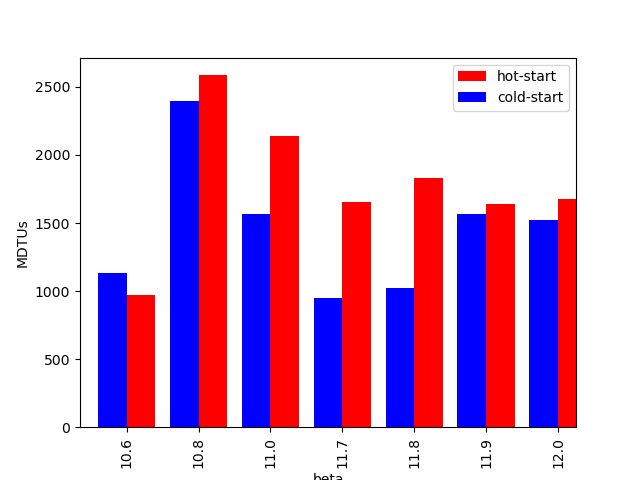

In [9]:
## Plot number of configs
df=df_sliced[(df_sliced.beta>10.5)&(df_sliced.beta<17.1)\
             &(df_sliced.Lx==16)&(df_sliced.Lt==8)&\
             (df_sliced.mf==0.1)]\
[['Lx','Lt','beta','run_label','num_conf']]
df.set_index('beta',inplace=True)

display(df)

width=0.4 

plt.figure()

label='hot-start'
df[df.run_label==label].num_conf.plot(kind='bar', width=width, color='red', position=0, label=label)

label='cold-start'
(df[df.run_label==label].num_conf).plot(kind='bar', width=width, color='blue', position=1, label=label)

plt.legend(loc='best')

plt.ylabel("MDTUs")
# plt.savefig('fig_output/num_confs_hot_cold.pdf')


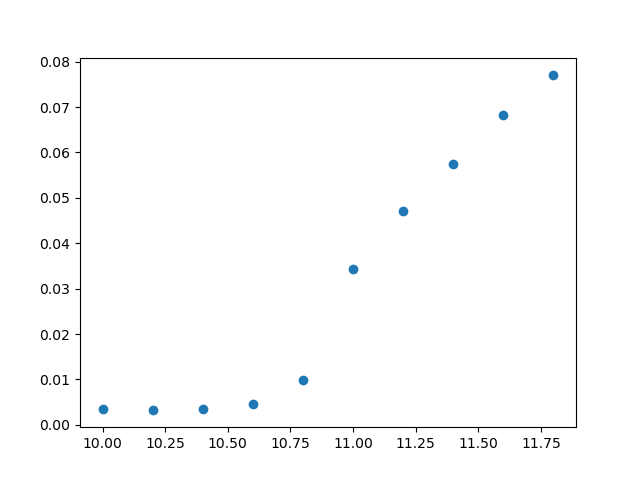

In [10]:
df=df_sliced[(((df_sliced.Lx==16)&(df_sliced.Lt==8))|((df_sliced.Lx==24)&(df_sliced.Lt==12)))\
             &(df_sliced.run_label=='hot-start')\
             &(df_sliced.mf==0.1)].reset_index(drop=True)


f_plot_vary_beta(df,'polyakov','Polyakov loop')
# f_plot_vary_beta(df,'plaq','Plaquette')
# f_plot_vary_beta(df,'sus_plaq','$\chi_{Plaquette}$')
# f_plot_vary_beta(df,'sus_poly','$\chi_{Polyakov}$')
# f_plot_vary_beta(df,'accept','Acceptance')

# f_plot_vary_beta(df,'traj_time','Traj time')

## HMC time series plots

In [11]:
def f_get_hmc_data(dict1,fname1):
    '''
    Given a dictionary, extract the time series for just that set of couplings
    '''

    sql_query='SELECT * FROM test \
    WHERE Lx={Lx} \
    AND Lt={Lt} \
    AND mf={mf} \
    AND beta IN {beta}\
    '.format(**dict1)
    
    print(sql_query)
    
    conn = sqlite3.connect(fname1)
    df_read=pd.read_sql_query(sql_query,conn)
    df_read['Polyakov']=df_read['Polyakov'].astype(np.complex128)
    conn.close()
    
    return df_read



fname1='Stored_data/sql_dbase_files/parsed_hmc.db'
dict1={'Lx':'16', 'Lt':'8','mf':'0.1',  'beta':'(10.8)' }
df_hmc=f_get_hmc_data(dict1,fname1)

SELECT * FROM test     WHERE Lx=16     AND Lt=8     AND mf=0.1     AND beta IN (10.8)    


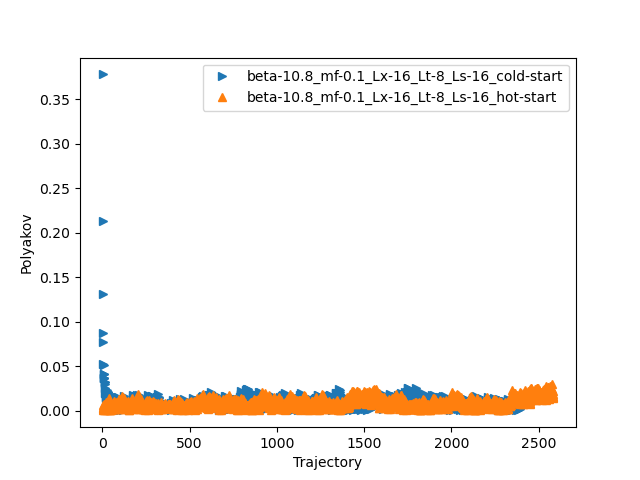

In [12]:
# f_plot_hmc_runs(df_hmc,'Plaquette')
# # plt.savefig('fig_output/Plaq_details.pdf')
f_plot_hmc_runs(df_hmc,'Polyakov')
# f_plot_hmc_runs(df_hmc,'Traj_time')
# f_plot_hmc_runs(df_hmc,'Accept')


SELECT * FROM test     WHERE Lx=16     AND Lt=8     AND mf=0.1     AND beta IN (10.6, 11.8)    


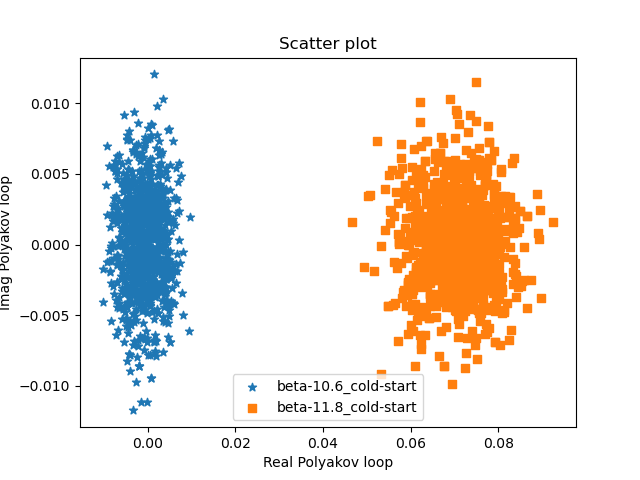

In [13]:

dict1={'Lx':'16', 'Lt':'8','mf':'0.1',  'beta':'(10.6, 11.8)' }
df_hmc=f_get_hmc_data(dict1,fname1)

df_hmc=df_hmc[df_hmc.run_label=='cold-start']

# f_ploop_histogram(df_hmc,100)
f_scatter_plot(df_hmc,50)